In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
import os
print(os.getcwd())


C:\Users\86134\深度学习原理和pytorch实战demo


In [3]:
import numpy as np
import pandas as pd  # 读取CSV文件的库
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
# 直接在Notebook中显示输出图像
%matplotlib inline

Text(0, 0.5, 'Y')

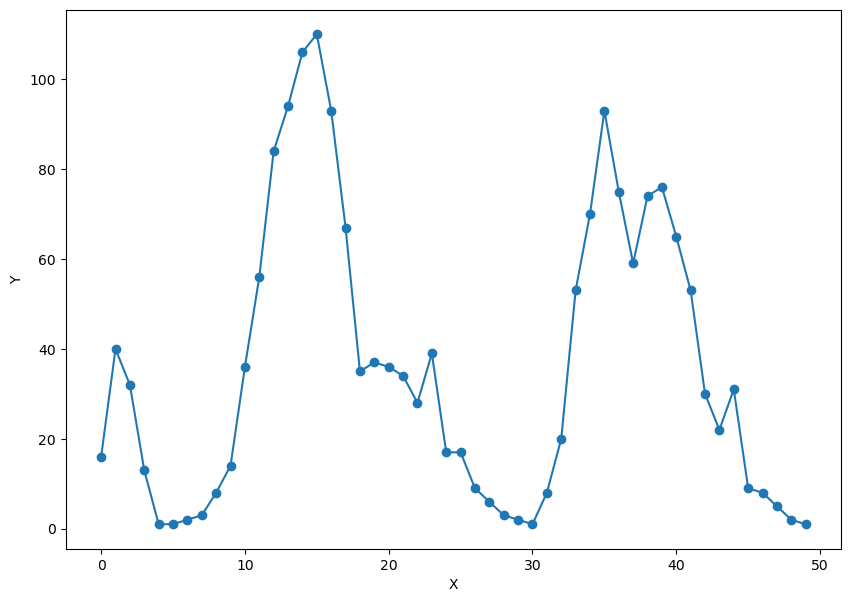

In [4]:
data_path = 'hour.csv'  # 读取数据到内存，rides为一个dataframe对象
rides = pd.read_csv(data_path)
rides.head()  # 输出部分数据
counts = rides['cnt'][:50]  # 截取数据
x = np.arange(len(counts))  # 获取变量x
y = np.array(counts) # 单车数量为y
plt.figure(figsize = (10, 7)) # 设定绘图窗口大小
plt.plot(x, y, 'o-')  # 绘制原始数据
plt.xlabel('X')  # 更改坐标轴标注
plt.ylabel('Y')  # 更改坐标轴标注

采用10个隐含单元就足以拟合这条曲线了

In [16]:
# 输入变量，1,2,3,...这样的一维数组
x = torch.FloatTensor(np.arange(len(counts), dtype = float) / len(counts))
# 输出变量，它是从数据counts中读取的每一时刻的单车数，共50个数据点的一维数组，作为标准答案
y = torch.FloatTensor(np.array(counts, dtype = float))

sz = 10  # 设置隐含神经元的数量
# 初始化输入层到隐含层的权重矩阵，它的尺寸是(1,10)
weights = torch.randn((1, sz), requires_grad = True)
# 初始化隐含层节点的偏置向量，它是尺寸为10的一维向量
biases = torch.randn((sz), requires_grad = True)
# 初始化从隐含层到输出层的权重矩阵，它的尺寸是(10,1)
weights2 = torch.randn((sz, 1), requires_grad = True)

## 设置好变量和神经网络的初始参数，接下来迭代地训练这个神经网络

In [17]:
#设置好变量和神经网络的初始参数，接下来迭代地训练这个神经网络
learning_rate = 0.001 # 设置学习率
losses = [] # 该数组记录每一次迭代的损失函数值，以方便后续绘图
x = x.view(50,-1)
y = y.view(50,-1)
for i in range(100000):
    # 从输入层到隐含层的计算
    hidden = x * weights + biases
    # 此时，hidden变量的尺寸是(50,10)，即50个数据点，10个隐含神经元

    # 将sigmoid函数应用在隐含层的每一个神经元上
    hidden = torch.sigmoid(hidden)
    # 隐含层输出到输出层，计算得到最终预测值
    predictions = hidden.mm(weights2)
    # 此时，predictions的尺寸为(50,1)，即50个数据点的预测值
    # 通过与数据中的标准答案y做比较，计算均方误差
    loss = torch.mean((predictions - y) ** 2)
    # 此时，loss为一个标量，即一个数
    losses.append(loss.data.numpy())

    if i % 10000 == 0: # 每隔10000个周期打印一下损失函数数值
        print('loss:', loss)

    # *****************************************
    # 接下来开始执行梯度下降算法，将误差反向传播
    loss.backward()  # 对损失函数进行梯度反传

    # 利用上一步计算中得到的weights、biases等梯度信息更新weights和biases的数值
    weights.data.add_(- learning_rate * weights.grad.data)
    biases.data.add_(- learning_rate * biases.grad.data)
    weights2.data.add_(- learning_rate * weights2.grad.data)

    # 清空所有变量的梯度值
    weights.grad.data.zero_()
    biases.grad.data.zero_()
    weights2.grad.data.zero_()

loss: tensor(2371.2598, grad_fn=<MeanBackward0>)
loss: tensor(890.0635, grad_fn=<MeanBackward0>)
loss: tensor(634.5158, grad_fn=<MeanBackward0>)
loss: tensor(462.8809, grad_fn=<MeanBackward0>)
loss: tensor(220.9129, grad_fn=<MeanBackward0>)
loss: tensor(119.3185, grad_fn=<MeanBackward0>)
loss: tensor(81.7928, grad_fn=<MeanBackward0>)
loss: tensor(66.4671, grad_fn=<MeanBackward0>)
loss: tensor(58.2657, grad_fn=<MeanBackward0>)
loss: tensor(52.7381, grad_fn=<MeanBackward0>)


Text(0, 0.5, 'Loss')

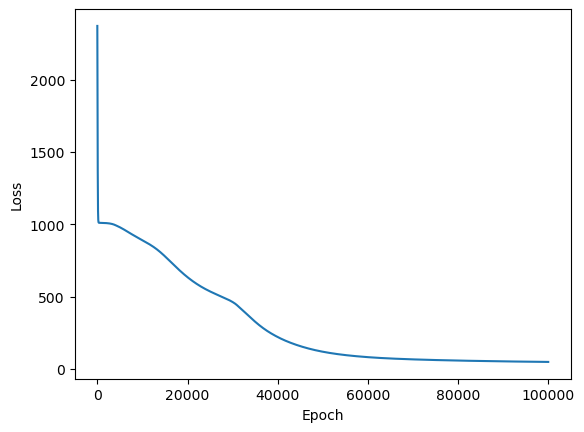

In [18]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')

# 发现问题

预测曲线在第一个波峰比较好地拟合了数据，但是在此后，它却与真实数据相差甚远。

# 解决问题
 x的取值范围是1~50，而所有权重和偏置的初始值都是设定在(-1, 1)的正态分布随机数，那么输入层到隐含层节点的数值范围就成了的-50到50，要想将sigmoid函数的多个峰值调节到我们期望的位置，需要耗费很多计算时间。事实上，如果让训练时间更长些，我们可以将曲线后面的部分拟合得很好

这个问题的解决方法是将输入数据的范围做归一化处理，也就是让x的输入数值范围为0~1。因为数据中x的范围是1到50，所以，我们只需要将每一个数值都除以50就可以了：

In [14]:
x = torch.FloatTensor(np.arange(len(counts), dtype = float) / len(counts))

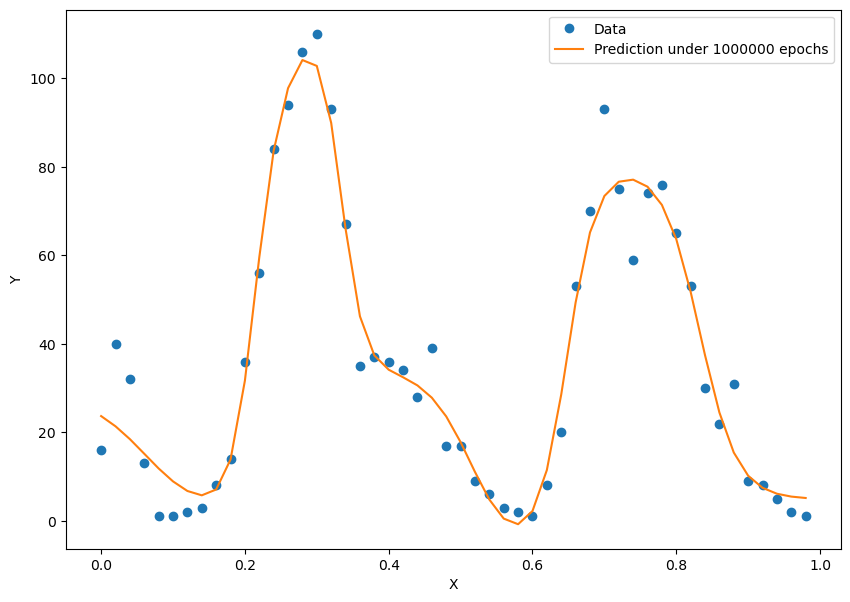

In [19]:
x_data = x.data.numpy()  # 获得x包裹的数据
plt.figure(figsize = (10, 7))  # 设定绘图窗口大小
xplot, = plt.plot(x_data, y.data.numpy(), 'o')  # 绘制原始数据
yplot, = plt.plot(x_data, predictions.data.numpy())  # 绘制拟合数据
plt.xlabel('X')  # 更改坐标轴标注
plt.ylabel('Y')  # 更改坐标轴标注
plt.legend([xplot, yplot],['Data', 'Prediction under 1000000 epochs'])  # 绘制图例
plt.show()

接下来，我们就需要用训练好的模型来做预测了。我们的预测任务是后面50条数据的单车数量。

tensor(6727.7705, grad_fn=<MeanBackward0>)


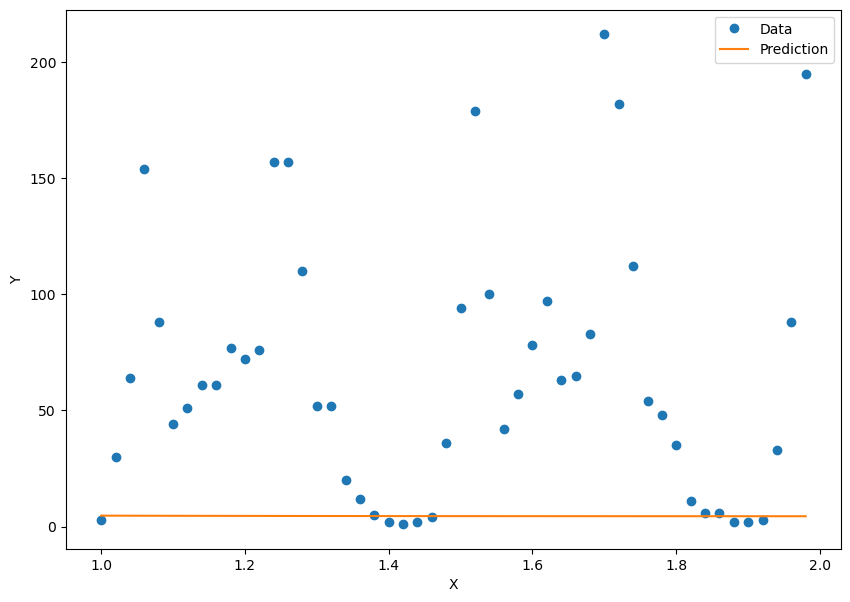

In [20]:
counts_predict = rides['cnt'][50:100]  # 读取待预测的后面50个数据点
x = torch.FloatTensor((np.arange(len(counts_predict), dtype = float) + len(counts)) / len(counts))
# 读取后面50个点的y数值，不需要做归一化
y = torch.FloatTensor(np.array(counts_predict, dtype = float))

# 用x预测y
hidden = x.expand(sz, len(x)).t() * weights.expand(len(x), sz)  # 从输入层到隐含层的计算
hidden = torch.sigmoid(hidden)  # 将sigmoid函数应用在隐含层的每一个神经元上
predictions = hidden.mm(weights2)  # 从隐含层输出到输出层，计算得到最终预测值
loss = torch.mean((predictions - y) ** 2)  # 计算预测数据上的损失函数
print(loss)

# 将预测曲线绘制出来
x_data = x.data.numpy()  # 获得x包裹的数据
plt.figure(figsize = (10, 7)) # 设定绘图窗口大小
xplot, = plt.plot(x_data, y.data.numpy(), 'o') # 绘制原始数据
yplot, = plt.plot(x_data, predictions.data.numpy())  # 绘制拟合数据
plt.xlabel('X')  # 更改坐标轴标注
plt.ylabel('Y')  # 更改坐标轴标注
plt.legend([xplot, yplot],['Data', 'Prediction'])  # 绘制图例
plt.show()

# 模型预测与实际数据竟然完全对不上！

出现了过拟合现象，所谓过拟合是指模型可以在训练数据上进行非常好的预测，但在全新的测试数据上表现不佳

问题在于：选择了错误的特征变量：我们尝试用数据的下标(1, 2, 3, …)或者它的归一化(0.1, 0.2, …)来对x进行预测。然而曲线的波动模式（也就是单车的使用数量）显然并不依赖于下标，而是依赖于诸如天气、风速、星期几和是否是节假日等因素。不能将不同类型的变量不加任何处理地输入神经网络，因为不同的数值代表完全不同的含义。在类型变量中，数字的大小实际上没有任何意义。比如数字5比数字1大，但这并不代表周五会比周一更特殊。

类型变量的大小没有任何含义，只是为了区分不同的类型而已。比如季节这个变量可以等于1、2、3、4，即四季，数字仅仅是对它们的区分。我们不能将season变量直接输入神经网络，因为season数值并不表示相应的信号强度。我们的解决方案是将类型变量转化为“独热编码”

采用这种编码后，不同的数值就转变为了不同的向量，这些向量的长度都是4，而只有一个位置为1，其他位置都是0。1代表激活，于是独热编码的向量就对应了不同的激活模式。这样的数据更容易被神经网络处理。更一般地，如果一个类型变量有n个不同的取值，那么我们的独热编码所对应的向量长度就为n。接下来，我们只需要在数据中将某一列类型变量转化为多个列的独热编码向量，就可以完成这种变量的预处理了

In [21]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday'] # 所有类型编码变量的名称
for each in dummy_fields:
    # 取出所有类型变量，并将它们转变为独热编码
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    # 将新的独热编码变量与原有的所有变量合并到一起
    rides = pd.concat([rides, dummies], axis=1)

# 将原来的类型变量从数据表中删除
fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 'weekday', 'atemp', 'mnth', 'workingday',
                  'hr'] # 要删除的类型变量的名称
data = rides.drop(fields_to_drop, axis=1) # 将它们从数据库的变量中删除

In [22]:
quant_features = ['cnt', 'temp', 'hum', 'windspeed'] # 数值类型变量的名称
scaled_features = {}  # 将每一个变量的均值和方差都存储到scaled_features变量中
for each in quant_features:
    # 计算这些变量的均值和方差
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    # 对每一个变量进行标准化
    data.loc[:, each] = (data[each] - mean)/std

# 数据集的划分

将变量集合分为特征和目标两个集合。其中，特征变量集合包括：年份(yr)、是否是节假日(holiday)、温度(temp)、湿度(hum)、风速(windspeed)、季节1至4(season)、天气1到4（weathersit，不同天气状况）、月份1到12(mnth)、小时0至23(hr)和星期0到6(weekday)，它们是输入给神经网络的变量。目标变量包括：用户数(cnt)、临时用户数(casual)，以及注册用户数(registered)。其中我们仅仅将cnt作为目标变量，另外两个暂时不做任何处理。

数据处理

In [39]:
test_data = data[-21*24:] # 选出训练集
train_data = data[:-21*24] # 选出测试集

# 目标列包含的字段
target_fields = ['cnt','casual', 'registered']

# 将训练集划分成特征变量列和目标特征列
features, targets = train_data.drop(target_fields, axis=1), train_data[target_fields]

# 将测试集划分成特征变量列和目标特征列
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

# 将数据类型转换为NumPy数组
X = features.values  # 将数据从pandas dataframe转换为NumPy
Y = targets['cnt'].values
Y = Y.astype(float)

Y = np.reshape(Y, [len(Y),1])
losses = []

# 构建神经网络


In [34]:
# 定义神经网络架构，features.shape[1]个输入单元，10个隐含单元，1个输出单元
input_size = features.shape[1]
hidden_size = 10
output_size = 1
batch_size = 128
neu = torch.nn.Sequential(
    torch.nn.Linear(input_size, hidden_size),
    torch.nn.Sigmoid(),
    torch.nn.Linear(hidden_size, output_size),
)

torch.nn.Sequential()这个函数的作用是将一系列的运算模块按顺序搭建成一个多层的神经网络。在本例中，这些模块包括从输入层到隐含层的线性映射Linear(input_size, hidden_size)、隐含层的非线性sigmoid函数torch.nn.Sigmoid()，以及从隐含层到输出层的线性映射torch.nn.Linear(hidden_size, output_size)。值得注意的是，Sequential里面的层次并不与神经网络的层次严格对应，而是指多步的运算，它与动态计算图的层次相对应

In [35]:
# 使用pytorch自带的损失函数
cost = torch.nn.MSELoss()

In [36]:
# PyTorch还自带了优化器来自动实现优化算法
optimizer = torch.optim.SGD(neu.parameters(), lr = 0.01)

# 数据批处理

0 0.9046183
100 0.2787117
200 0.25446716
300 0.20549516
400 0.12591472
500 0.08568245
600 0.07340267
700 0.06826684
800 0.065211006
900 0.06303747


Text(0, 0.5, 'MSE')

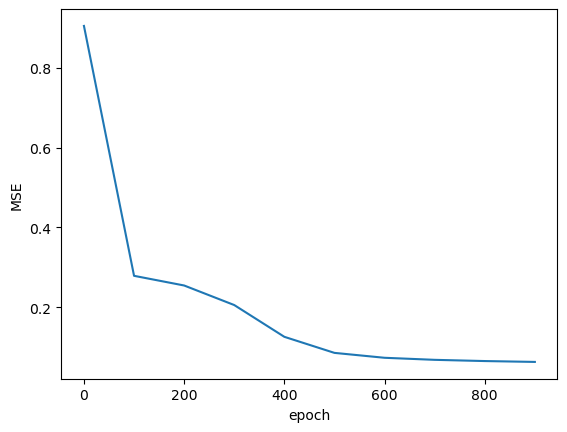

In [40]:
# 神经网络训练循环
losses = []
X = np.array(X, dtype=np.float32)
for i in range(1000):
    # 每128个样本点划分为一批，在循环的时候一批一批地读取
    batch_loss = []
    # start和end分别是提取一批数据的起始下标和终止下标
    for start in range(0, len(X), batch_size):
        end = start + batch_size if start + batch_size < len(X) else len(X)
        xx = torch.FloatTensor(X[start:end])
        yy = torch.FloatTensor(Y[start:end])
        predict = neu(xx)
        loss = cost(predict, yy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.data.numpy())

    # 每隔100步输出损失值
    if i % 100==0:
        losses.append(np.mean(batch_loss))
        print(i, np.mean(batch_loss))

# 打印输出损失值
plt.plot(np.arange(len(losses))*100,losses)
plt.xlabel('epoch')
plt.ylabel('MSE')

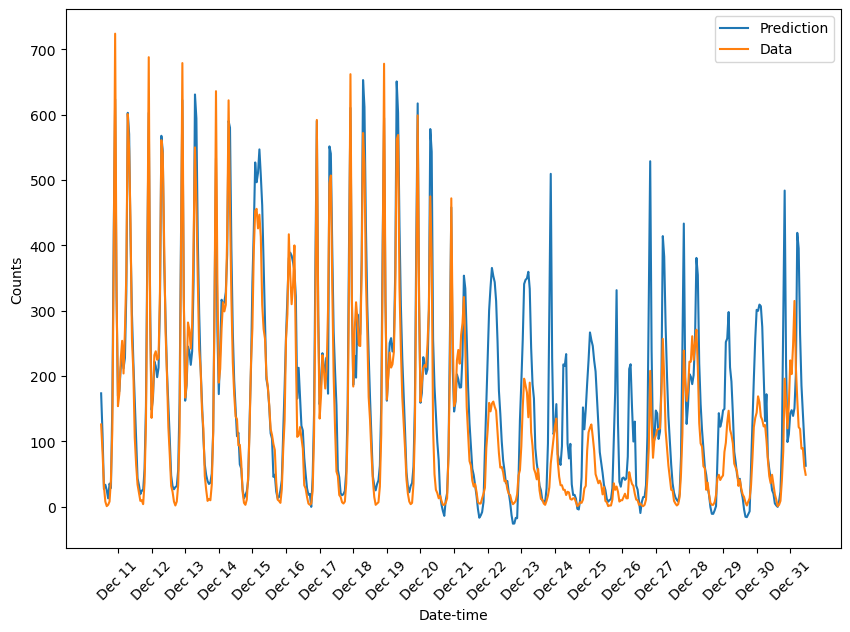

In [42]:
targets = test_targets['cnt']  # 读取测试集的cnt数值
targets = targets.values.reshape([len(targets),1])  # 将数据转换成合适的张量形式
targets = targets.astype(float)  # 保证数据为实数

x = torch.FloatTensor(test_features.values.astype(float))
y = torch.FloatTensor(targets)

# 用神经网络进行预测
predict = neu(x)
predict = predict.data.numpy()

fig, ax = plt.subplots(figsize = (10, 7))

mean, std = scaled_features['cnt']
ax.plot(predict * std + mean, label='Prediction')
ax.plot(targets * std + mean, label='Data')
ax.legend()
ax.set_xlabel('Date-time')
ax.set_ylabel('Counts')
dates = pd.to_datetime(rides.loc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

可以看到，两条曲线基本是吻合的，但是在12月25日前后几天的实际值和预测值偏差较大。为什么这段时间的表现这么差呢？仔细观察数据，我们发现12月25日正好是圣诞节。对于欧美国家来说，圣诞节就相当于我们的春节，在圣诞节假期前后，人们的出行习惯会与往日有很大的不同。但是，在我们的训练样本中，因为整个数据仅有两年的长度，所以包含圣诞节前后的样本仅有一次，这就导致我们没办法对这一假期的模式进行很好的预测